In [19]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from scipy.interpolate import griddata, LinearNDInterpolator
import astra
from matplotlib import pyplot as plt

In [20]:
def rebin_fan2par(sinogram, original_angles, source_obj_distance, new_angles, magnification, interpolation_method='knn'):
    """
    Rebin a fan-beam sinogram into a parallel-beam sinogram with selectable interpolation methods.

    Parameters:
    - sinogram: 2D NumPy array, the fan-beam sinogram.
    - original_angles: 1D array, angles in degrees for the fan-beam sinogram.
    - source_obj_distance: float, distance from source to object.
    - new_angles: 1D array, angles in degrees for the parallel-beam sinogram.
    - magnification: float, magnification factor (source-to-detector ratio).
    - interpolation_method: str, method to use for interpolation ('knn', 'griddata', or 'linearnd').

    Returns:
    - F: 2D NumPy array, the re-binned parallel-beam sinogram.
    """
    # Determine the size of the sinogram
    sinogram = sinogram.T
    n_pixels = sinogram.shape[0]
    n_pixels_new = n_pixels

    # Flip sinogram along the second dimension
    sinogram = np.flip(sinogram, axis=1)

    # Compute detector pixel positions
    pixel_positions = np.arange(-(n_pixels - 1) / 2, (n_pixels - 1) / 2 + 1)

    # Calculate gamma angles
    angles_to_pixels = np.arctan(pixel_positions / (magnification * source_obj_distance))

    # Create meshgrid for beta (angles) and gamma (detector)
    beta, gamma = np.meshgrid(np.radians(original_angles), angles_to_pixels)

    # Calculate t and theta
    t = magnification * source_obj_distance * np.sin(gamma)
    theta = np.degrees(gamma) + np.degrees(beta)

    # Recalculate for new detector pixel positions
    pixel_positions_new = np.arange(-(n_pixels_new - 1) / 2, (n_pixels_new - 1) / 2 + 1)
    angles_to_pixels_new = np.arctan(pixel_positions_new / (magnification * source_obj_distance))

    _, gamma_new = np.meshgrid(np.radians(original_angles), angles_to_pixels_new)
    tnew = magnification * source_obj_distance * np.sin(gamma_new)

    # Define uniform t_parallel grid
    t_para = np.linspace(tnew.min(), tnew.max(), n_pixels_new)
    # Create meshgrid for thetaNewCoord and t_para
    thetaNewCoord, tNewCoord = np.meshgrid(new_angles, t_para)

    # Flatten input data (coordinates and values)
    points = np.column_stack((theta.ravel(), t.ravel()))  # Combine theta and t into coordinate pairs
    values = sinogram.ravel()  # Flatten the sinogram data

    # Flatten the target grid for interpolation
    target_points = np.column_stack((thetaNewCoord.ravel(), tNewCoord.ravel()))

    # Interpolation based on the selected method
    if interpolation_method == 'knn':
        # Use KNN for local interpolation
        knn = KNeighborsRegressor(n_neighbors=20, weights='distance')
        knn.fit(points, values)
        F_flat = knn.predict(target_points)
    elif interpolation_method == 'griddata':
        # Use griddata interpolation (e.g., cubic interpolation)
        F_flat = griddata(points, values, target_points, method='cubic', fill_value=0)
    elif interpolation_method == 'linearnd':
        # Use LinearNDInterpolator for scattered data
        interpolant = LinearNDInterpolator(points, values, fill_value=0)
        F_flat = interpolant(target_points)
    else:
        raise ValueError(f"Unsupported interpolation method: {interpolation_method}")

    # Reshape the interpolated result back into the desired grid shape
    F = F_flat.reshape(thetaNewCoord.shape)

    # Flip the result to match the desired orientation
    F = np.flip(F, axis=(0, 1))
    

    return F



In [21]:
def fanbeam_sinogram_generator(P, angles, source_origin_distance, source_detector_distance, 
                                          detSubSamp, detector_pixel_size, 
                                          detector_cols, detector_rows):
    """
    Perform fan-beam projection and reconstruction using ASTRA Toolbox.
    
    Parameters:
    - P: Ground truth image(s), with size (N, M).
    - angles: Array of angles for the projections (e.g., np.linspace(0, 2*np.pi, 360)).
    - SOD: Source-to-object distance.
    - SDD: Source-to-detector distance.
    - detSubSamp: Detector subsampling factor.
    - detector_pixel_size: Size of the detector pixels.
    - detector_cols: Number of columns in the detector.
    - detector_rows: Number of rows in the detector.
    - scale: Scaling factor for the detector.
    - iterations: Number of iterations for the reconstruction algorithm.
    - percentage: The percentage of Gaussian noise to add (default is 5%).
    
    Returns:
    - reconstruction: The reconstructed image from the sinogram.
    """

    # Step 1: Scale and voxel calculations
    detector_pixel_size *= detSubSamp    
    voxel_size = detector_pixel_size * source_origin_distance / source_detector_distance
    distance_origin_detector = source_detector_distance - source_origin_distance
    distance_source_origin = source_origin_distance

    # Apply scale factor
    detector_pixel_size *= detSubSamp  
    voxel_size = detector_pixel_size * source_origin_distance / source_detector_distance
    distance_origin_detector = source_detector_distance - source_origin_distance

    # Step 2: Create vectors for fan-beam projection geometry
    vectors = np.zeros((len(angles), 6))
    for i in range(len(angles)):
        vectors[i, 0] = np.sin(angles[i]) * distance_source_origin / voxel_size
        vectors[i, 1] = -np.cos(angles[i]) * distance_source_origin / voxel_size
        vectors[i, 2] = -np.sin(angles[i]) * distance_origin_detector / voxel_size
        vectors[i, 3] = np.cos(angles[i]) * distance_origin_detector / voxel_size
        vectors[i, 4] = np.cos(angles[i]) * detector_pixel_size / voxel_size
        vectors[i, 5] = np.sin(angles[i]) * detector_pixel_size / voxel_size

    # Step 3: Create projection and volume geometry
    proj_geom = astra.create_proj_geom('fanflat_vec', detector_cols // detSubSamp, vectors)
    
    vol_geom = astra.create_vol_geom(detector_cols // detSubSamp, detector_cols // detSubSamp)

    # Step 4: Create an ASTRA data ID for the ground truth image
    vol_data_id = astra.data2d.create('-vol', vol_geom, data=P)

    # Step 5: Create sinogram data for forward projection
    sinogram_id = astra.data2d.create('-sino', proj_geom)
   
    # Step 6: Perform forward projection to create the sinogram using a projector
    cfg = astra.astra_dict('FP_CUDA')  # Forward projection with CUDA
    cfg['VolumeDataId'] = vol_data_id  # Ground truth volume
    cfg['ProjectionDataId'] = sinogram_id  # Sinogram to be filled
    fp_alg_id = astra.algorithm.create(cfg)  # Create forward projection algorithm
    astra.algorithm.run(fp_alg_id, 1)  # Run the forward projection

    # Step 7: Get the sinogram data
    sinogram = astra.data2d.get(sinogram_id)  
    
   

    return sinogram, proj_geom



def parallel_beam_sinogram_generator(P, num_detectors, detector_spacing, angles):
    """
    Generate a parallel-beam sinogram from a given phantom using ASTRA Toolbox.

    Parameters:
    - phantom: 2D NumPy array representing the input image/phantom.
    - num_detectors: int, number of detector pixels in the sinogram.
    - detector_spacing: float, spacing between detector pixels.
    - angles: 1D NumPy array of projection angles (in radians).

    Returns:
    - sinogram: 2D NumPy array representing the parallel-beam sinogram.
    - proj_geom: ASTRA projection geometry for the parallel-beam setup.
    """
    # Define volume geometry matching the phantom size
    vol_geom = astra.create_vol_geom(P.shape[0], P.shape[1])

    # Create parallel-beam projection geometry
    proj_geom = astra.create_proj_geom('parallel', detector_spacing, num_detectors, angles)

    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    # Generate the sinogram
    sinogram_id, sinogram = astra.create_sino(P, proj_id)

    # Clean up ASTRA resources
    astra.data2d.delete(sinogram_id)

    return sinogram, proj_geom

## Get the sinogram from fan-beam setting 

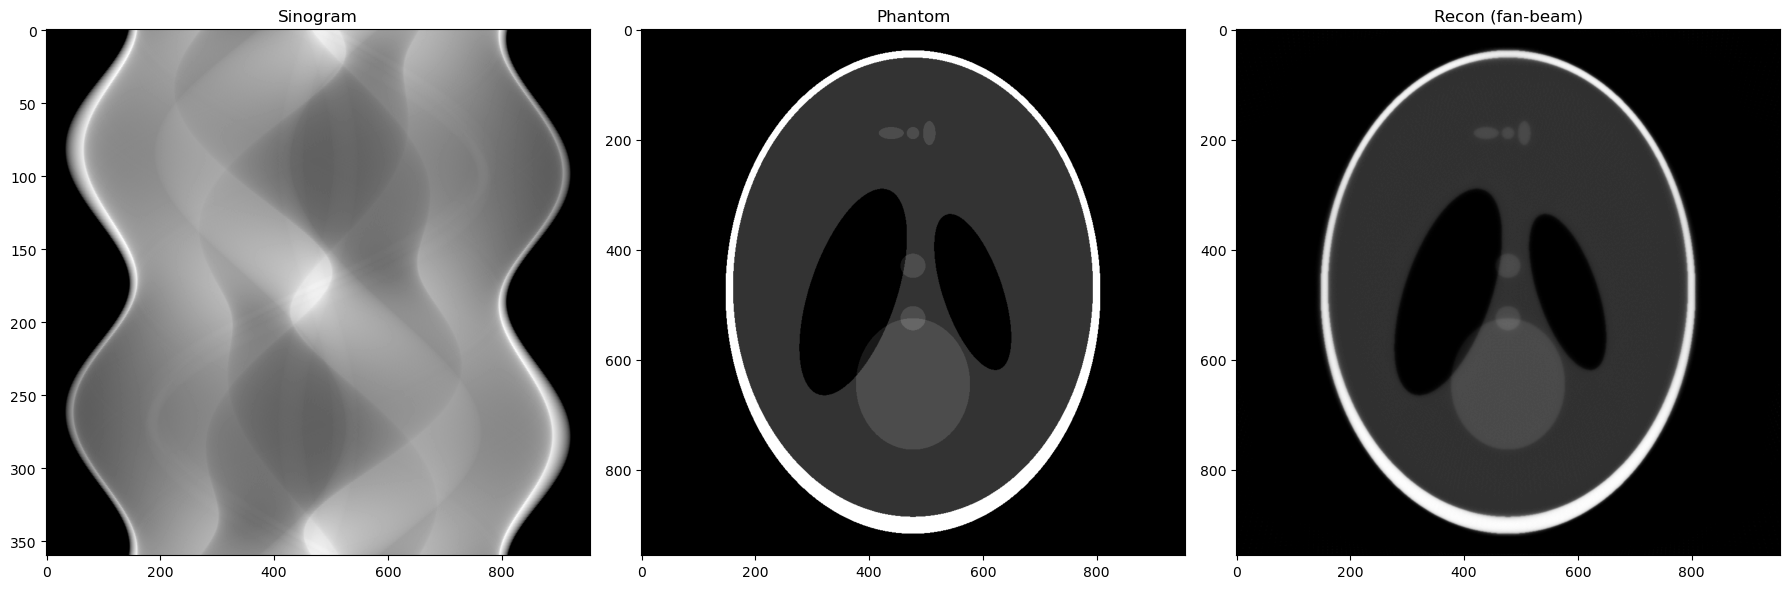

In [22]:
from phantominator import shepp_logan
image_size = 956  # Size of the test image
#phantom = np.zeros((image_size, image_size))  # Create an empty test image
#phantom[373:599, 373:599] = 1  # Add a square in the center for testing
phantom = shepp_logan(image_size)
source_origin_distance = 224.96754
source_detector_distance = 449.99152299999996
detSubSamp=1 
detector_pixel_size=0.14960000051532416 
detector_cols=956 
detector_rows=10


source_origin_distance_pixel = source_origin_distance/detector_pixel_size
source_detector_distance_pixel = source_detector_distance/detector_pixel_size
magnification = source_detector_distance/source_origin_distance

angles = np.linspace(0, 2*np.pi, 360, endpoint=False)  # Projections over 180 degrees

# Generate the fan-beam sinogram
sinogram, proj_geom = fanbeam_sinogram_generator(
    phantom, angles, source_origin_distance, source_detector_distance, detSubSamp, detector_pixel_size, detector_cols, detector_rows)


vol_geom = astra.create_vol_geom(image_size, image_size)

proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    # construct the OpTomo object
    
W = astra.OpTomo(proj_id)

    
    
rec_sirt_fan = W.reconstruct('SIRT_CUDA', sinogram, iterations=150, extraOptions={'MinConstraint':0.0})






# Create a figure with side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 2 columns

# Plot the sinogram
axes[0].imshow(sinogram, cmap='gray', aspect='auto')
axes[0].set_title("Sinogram")
#axes[0].axis('off')  # Hide axes for better visualization

# Plot the phantom
axes[1].imshow(phantom, cmap='gray', aspect='auto')
axes[1].set_title("Phantom")
#axes[1].axis('off')  # Hide axes for better visualization

axes[2].imshow(rec_sirt_fan, cmap='gray', aspect='auto')
axes[2].set_title("Recon (fan-beam)")
#axes[2].axis('off')  # Hide axes for better visualization

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Rebin the geometry from fan-beam to parallel-beam

In [23]:
# Convert fan-beam to parallel-beam using the custom rebin function
new_angles = np.linspace(0, 2*np.pi, 360, endpoint=False)  # Parallel beam angles

angles_input = np.linspace(0, 360, 360, endpoint=False)
new_angles_input = np.linspace(0, 360, 360, endpoint=False)


parallel_sinogram_rebin = rebin_fan2par(sinogram, angles_input, source_origin_distance_pixel, new_angles_input, magnification)
parallel_sinogram_rebin = parallel_sinogram_rebin.T

## Refine the sinogram, change the angle range from [0, 360) to [0, 180)

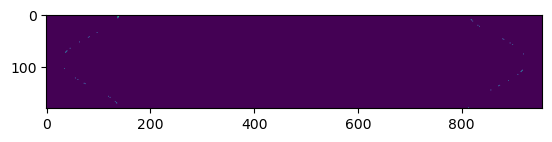

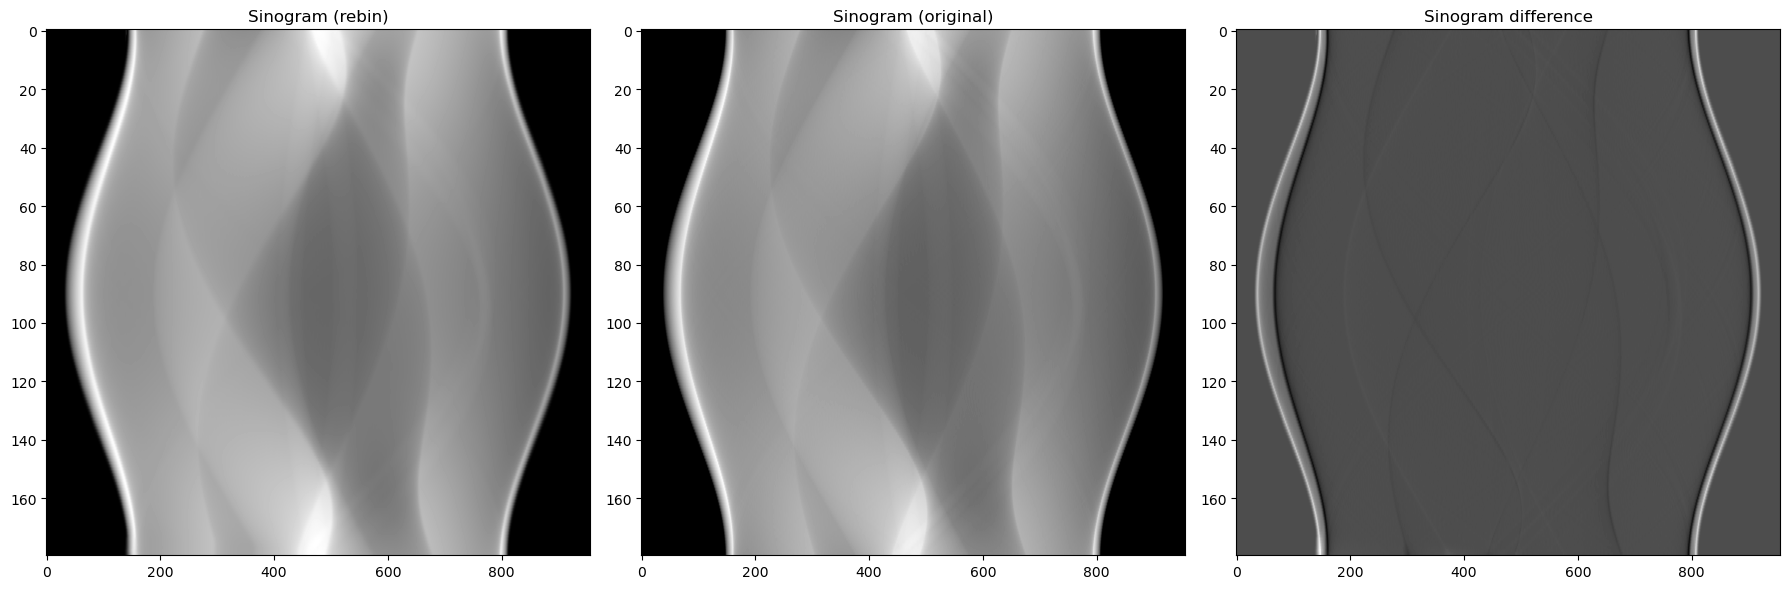

In [24]:
new_angles_s = np.linspace(0, np.pi, 180, endpoint=False)

# Create a mask for non-zero elements
array1 = parallel_sinogram_rebin[180:360,:]
array2 = np.flip(parallel_sinogram_rebin[0:180,:],axis=1)
non_zero_mask1 = array1 != 0
non_zero_mask2 = array2 != 0
#parallel_sinogram_rebin = np.where(
#    non_zero_mask1 & non_zero_mask2,  # Both values are non-zero
#    (array1 + array2) / 2,            # Average the values
#    np.where(non_zero_mask1, array1, array2)  # Replace with non-zero value
#)
# Create a mask where array1 is zero and array2 is non-zero
fill_mask = (array1 == 0) & (array2 != 0)

plt.figure()
plt.imshow(fill_mask)

# Replace zero values in array1 with corresponding non-zero values from array2
parallel_sinogram_rebin = np.where(fill_mask, array2, array1)



parallel_sinogram_original, _ = parallel_beam_sinogram_generator(phantom, 956, 1.0, new_angles_s)



# Create a figure with side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 2 columns

# Plot the sinogram
axes[0].imshow(parallel_sinogram_rebin, cmap='gray', aspect='auto')
axes[0].set_title("Sinogram (rebin)")
#axes[0].axis('off')  # Hide axes for better visualization

# Plot the sinogram
axes[1].imshow(parallel_sinogram_original, cmap='gray', aspect='auto')
axes[1].set_title("Sinogram (original)")
#axes[1].axis('off')  # Hide axes for better visualization



# Plot the difference
axes[2].imshow(parallel_sinogram_rebin-parallel_sinogram_original, cmap='gray', aspect='auto')
axes[2].set_title("Sinogram difference")
#axes[2].axis('off')  # Hide axes for better visualization

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

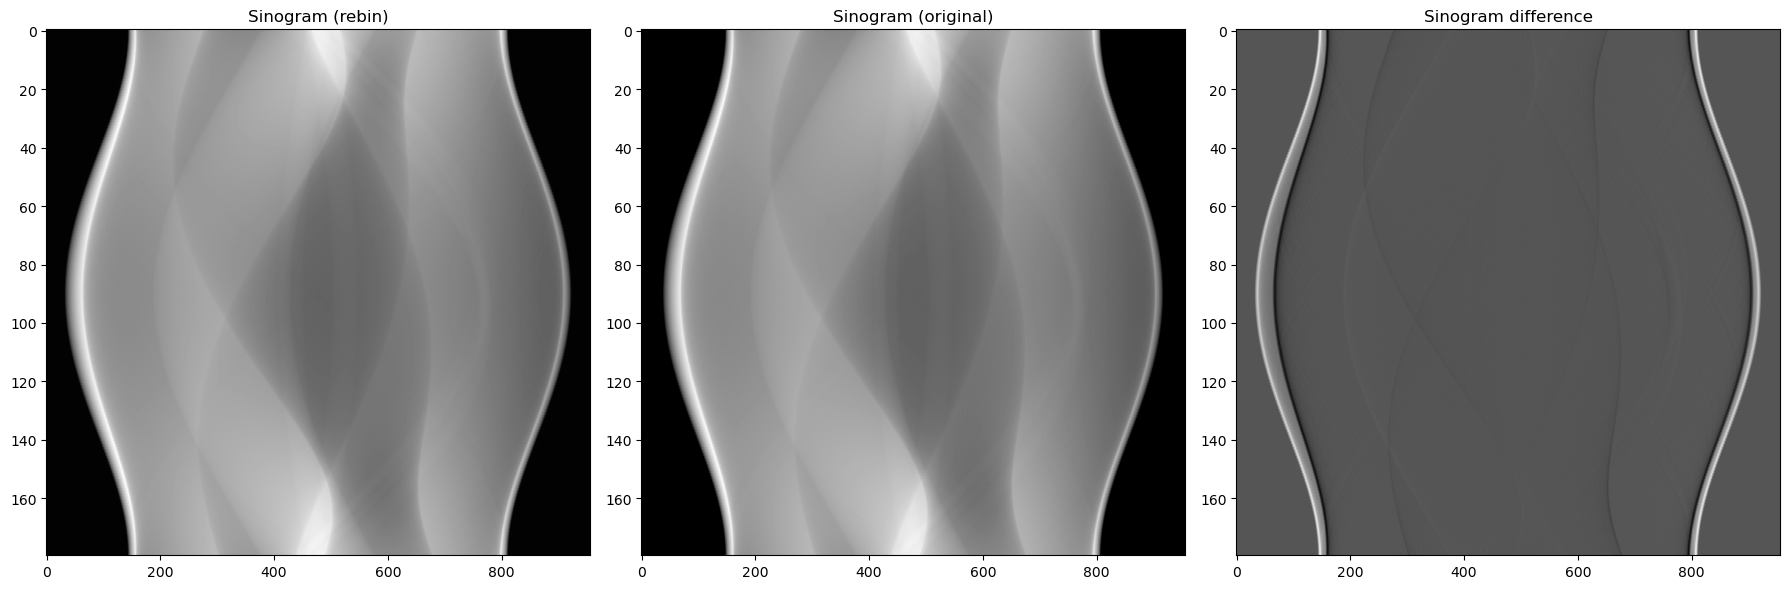

In [17]:
new_angles_s = np.linspace(0, np.pi, 180, endpoint=False)

# Create a mask for non-zero elements
array1 = parallel_sinogram_rebin[180:360,:]
array2 = np.flip(parallel_sinogram_rebin[0:180,:],axis=1)
non_zero_mask1 = array1 != 0
non_zero_mask2 = array2 != 0
parallel_sinogram_rebin = np.where(
    non_zero_mask1 & non_zero_mask2,  # Both values are non-zero
    (array1 + array2) / 2,            # Average the values
    np.where(non_zero_mask1, array1, array2)  # Replace with non-zero value
)
# Create a mask where array1 is zero and array2 is non-zero
#fill_mask = (array1 == 0) & (array2 != 0)

#plt.figure()
#plt.imshow(fill_mask)

# Replace zero values in array1 with corresponding non-zero values from array2
#parallel_sinogram_rebin = np.where(fill_mask, array2, array1)



parallel_sinogram_original, _ = parallel_beam_sinogram_generator(phantom, 956, 1.0, new_angles_s)



# Create a figure with side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 2 columns

# Plot the sinogram
axes[0].imshow(parallel_sinogram_rebin, cmap='gray', aspect='auto')
axes[0].set_title("Sinogram (rebin)")
#axes[0].axis('off')  # Hide axes for better visualization

# Plot the sinogram
axes[1].imshow(parallel_sinogram_original, cmap='gray', aspect='auto')
axes[1].set_title("Sinogram (original)")
#axes[1].axis('off')  # Hide axes for better visualization



# Plot the difference
axes[2].imshow(parallel_sinogram_rebin-parallel_sinogram_original, cmap='gray', aspect='auto')
axes[2].set_title("Sinogram difference")
#axes[2].axis('off')  # Hide axes for better visualization

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Reconstruction using parallel_sinogram_rebin

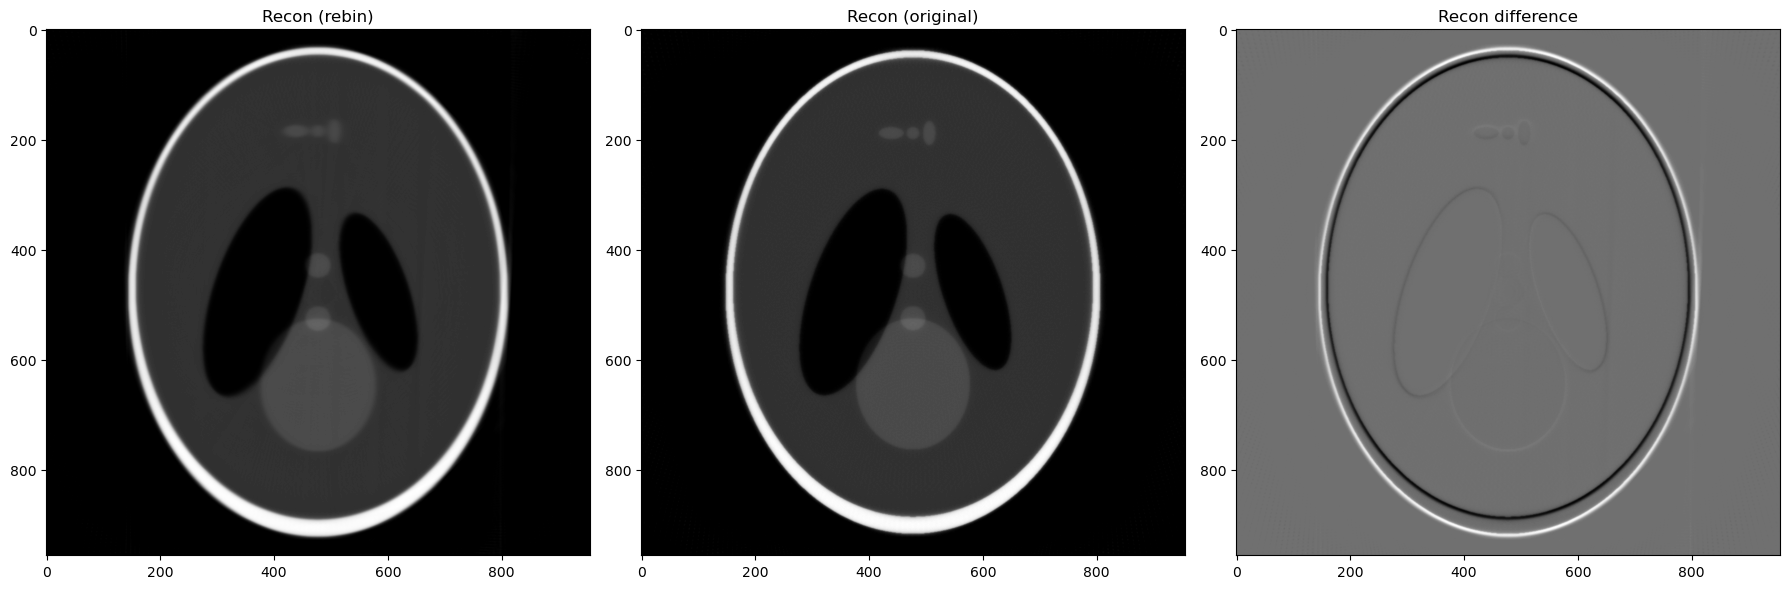

In [25]:
# parallel_sinogram = np.flip(F_smooth,axis=(0,1))
num_projections = parallel_sinogram_rebin.shape[0]  # Number of projection angles
num_detectors = parallel_sinogram_rebin.shape[1]    # Number of detector pixels
detector_spacing = 1.0               # Detector pixel spacing
# angles = np.linspace(0, np.pi, num_projections, endpoint=False)  # Parallel-beam angles

# Define the projection geometry
proj_geom = astra.create_proj_geom('parallel', detector_spacing, num_detectors, new_angles_s)

# Define the volume geometry for the reconstruction
image_size = 956  # Reconstructed image size (square)
vol_geom = astra.create_vol_geom(image_size, image_size)

proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    # construct the OpTomo object
    
W = astra.OpTomo(proj_id)
    
    
rec_sirt_rebin = W.reconstruct('SIRT_CUDA', parallel_sinogram_rebin, iterations=150, extraOptions={'MinConstraint':0.0})

rec_sirt_original = W.reconstruct('SIRT_CUDA', parallel_sinogram_original, iterations=150, extraOptions={'MinConstraint':0.0})


# Create a figure with side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 2 columns

# Plot the recon from rebin
axes[0].imshow(rec_sirt_rebin, cmap='gray', aspect='auto')
axes[0].set_title("Recon (rebin)")
#axes[0].axis('off')  # Hide axes for better visualization

# Plot the recon from fan-beam
axes[1].imshow(rec_sirt_original, cmap='gray', aspect='auto')
axes[1].set_title("Recon (original)")
#axes[1].axis('off')  # Hide axes for better visualization



# Plot the recon difference
axes[2].imshow(rec_sirt_rebin-rec_sirt_original, cmap='gray', aspect='auto')
axes[2].set_title("Recon difference")
#axes[2].axis('off')  # Hide axes for better visualization

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

